In [8]:
# Load and visualize the data
#dataset downloaded from https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data?resource=download
import pandas as pd
df = pd.read_csv("/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31 2.csv")

#delete the other columns
df.drop(['Open',"High","Low","Volume_(BTC)","Volume_(Currency)","Weighted_Price"], axis=1, inplace=True)

#make datetime readable
df['datetime'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('datetime')
df.drop(['Timestamp'], axis=1, inplace=True)

#drop the NaN
df = df.dropna(subset=['Close'])

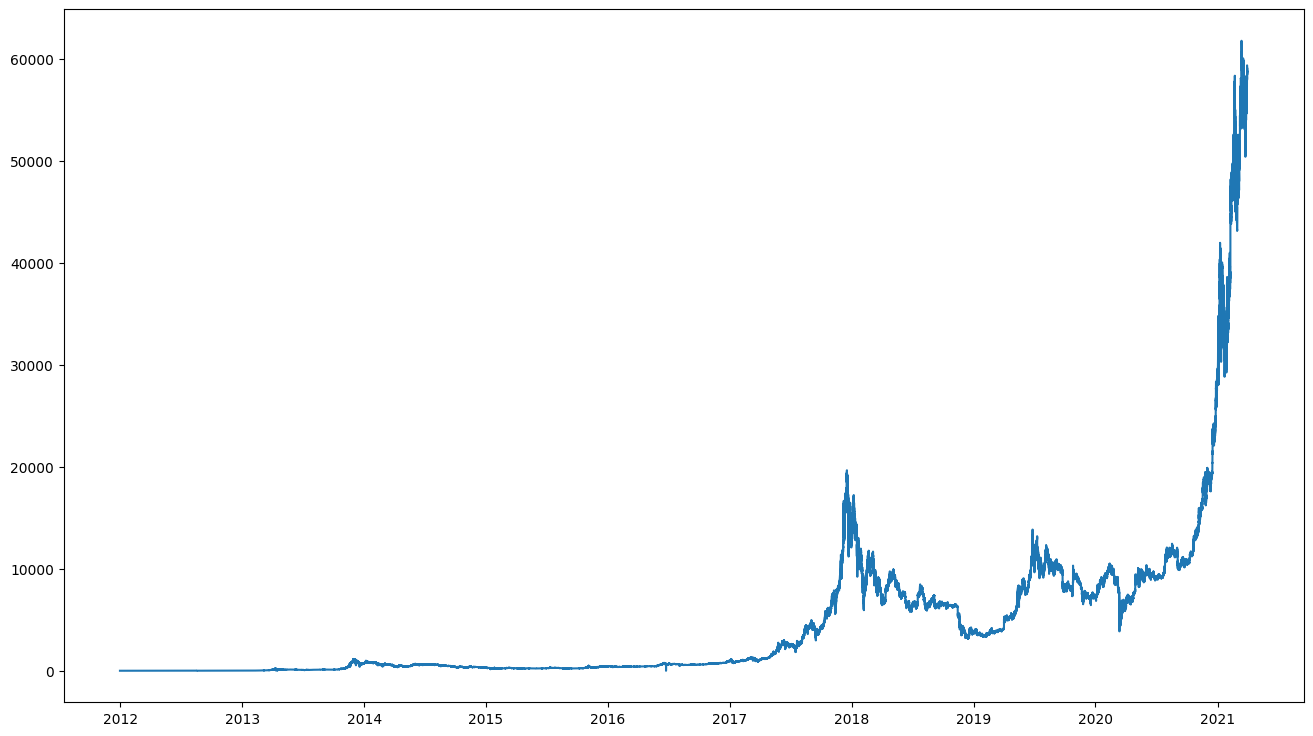

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(df.index, df["Close"]);

In [12]:
#pre processing (close column, normalizing, spilt dataset)
import numpy as np
import pandas as pd


from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(df)
scaled_df = pd.DataFrame(d, columns=df.columns)
scaled_df

temp = scaled_df['Close']
temp.head(), temp.tail(), temp.shape




(0    0.000047
 1    0.000047
 2    0.000050
 3    0.000050
 4    0.000050
 Name: Close, dtype: float64,
 3613764    0.949890
 3613765    0.949887
 3613766    0.950503
 3613767    0.951098
 3613768    0.951382
 Name: Close, dtype: float64,
 (3613769,))

In [13]:
train = temp[:3000000]
valid = temp[3000000:3300000]
test  = temp[3300000:]
train, valid, test

(0          0.000047
 1          0.000047
 2          0.000050
 3          0.000050
 4          0.000050
              ...   
 2999995    0.134803
 2999996    0.134920
 2999997    0.134679
 2999998    0.134691
 2999999    0.134626
 Name: Close, Length: 3000000, dtype: float64,
 3000000    0.134688
 3000001    0.134570
 3000002    0.134570
 3000003    0.134531
 3000004    0.134493
              ...   
 3299995    0.187167
 3299996    0.187167
 3299997    0.187167
 3299998    0.187037
 3299999    0.186990
 Name: Close, Length: 300000, dtype: float64,
 3300000    0.186949
 3300001    0.187044
 3300002    0.187000
 3300003    0.186940
 3300004    0.186971
              ...   
 3613764    0.949890
 3613765    0.949887
 3613766    0.950503
 3613767    0.951098
 3613768    0.951382
 Name: Close, Length: 313769, dtype: float64)

In [15]:
def df2Xy(df, windowSize=5):
  dfNumpy = df.to_numpy()
  X, y = [], []
  for i in range(len(dfNumpy)-windowSize):
    # inputs: X rows
    # form a row of X with starting index i from dfNumpy
    row = [[a] for a in dfNumpy[i:i+windowSize]]
    X.append(row)
    # outputs: y labels
    label = dfNumpy[i+windowSize]
    y.append(label)
  return (np.array(X), np.array(y))

WINDOW_SIZE = 7
Xtrain, yTrain = df2Xy(train, WINDOW_SIZE)
Xvalid, yValid = df2Xy(valid, WINDOW_SIZE)
Xtest, yTest = df2Xy(test, WINDOW_SIZE)

Xtrain.shape, Xvalid.shape, Xtest.shape, yTrain.shape, yValid.shape, yTest.shape


((2999993, 7, 1),
 (299993, 7, 1),
 (313762, 7, 1),
 (2999993,),
 (299993,),
 (313762,))

In [16]:
#design LSTM
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(InputLayer((7, 1)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

cp = ModelCheckpoint('/content/CP', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['acc'])



In [17]:
print("X_train: ", Xtrain.shape)
print("X_test: ", Xtest.shape)

X_train:  (2999993, 7, 1)
X_test:  (313762, 7, 1)


In [18]:
#evualate model and find Y pred
history = model.fit(Xtrain, yTrain, validation_data=(Xvalid, yValid), epochs=3, callbacks=[cp])

Epoch 1/3
93750/93750 [==============================] - 558s 6ms/step - loss: 1.4021e-05 - acc: 3.3333e-07 - val_loss: 6.3725e-08 - val_acc: 0.0000e+00
Epoch 2/3
93750/93750 [==============================] - 587s 6ms/step - loss: 6.0962e-08 - acc: 3.3333e-07 - val_loss: 9.3155e-08 - val_acc: 0.0000e+00
Epoch 3/3
93750/93750 [==============================] - 543s 6ms/step - loss: 5.7787e-08 - acc: 3.3333e-07 - val_loss: 5.7419e-08 - val_acc: 0.0000e+00


In [19]:
#evualate model and find Y pred
from tensorflow.keras.models import load_model
model2 = load_model('/content/CP')
train_predictions = model2.predict(Xtrain).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':yTrain})
train_results

93750/93750 [==============================] - 221s 2ms/step


,Train Predictions,Actuals
0,0.000060,0.000057
1,0.000061,0.000062
2,0.000063,0.000059
3,0.000064,0.000061
4,0.000066,0.000061
...,...,...
2999988,0.134668,0.134803
2999989,0.134721,0.134920
2999990,0.134784,0.134679
2999991,0.134787,0.134691


In [ ]:
val_predictions = model2.predict(Xvalid).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':yValid})

test_predictions = model2.predict(Xtest).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':yTest})

9806/9806 [==============================] - 45s 5ms/step


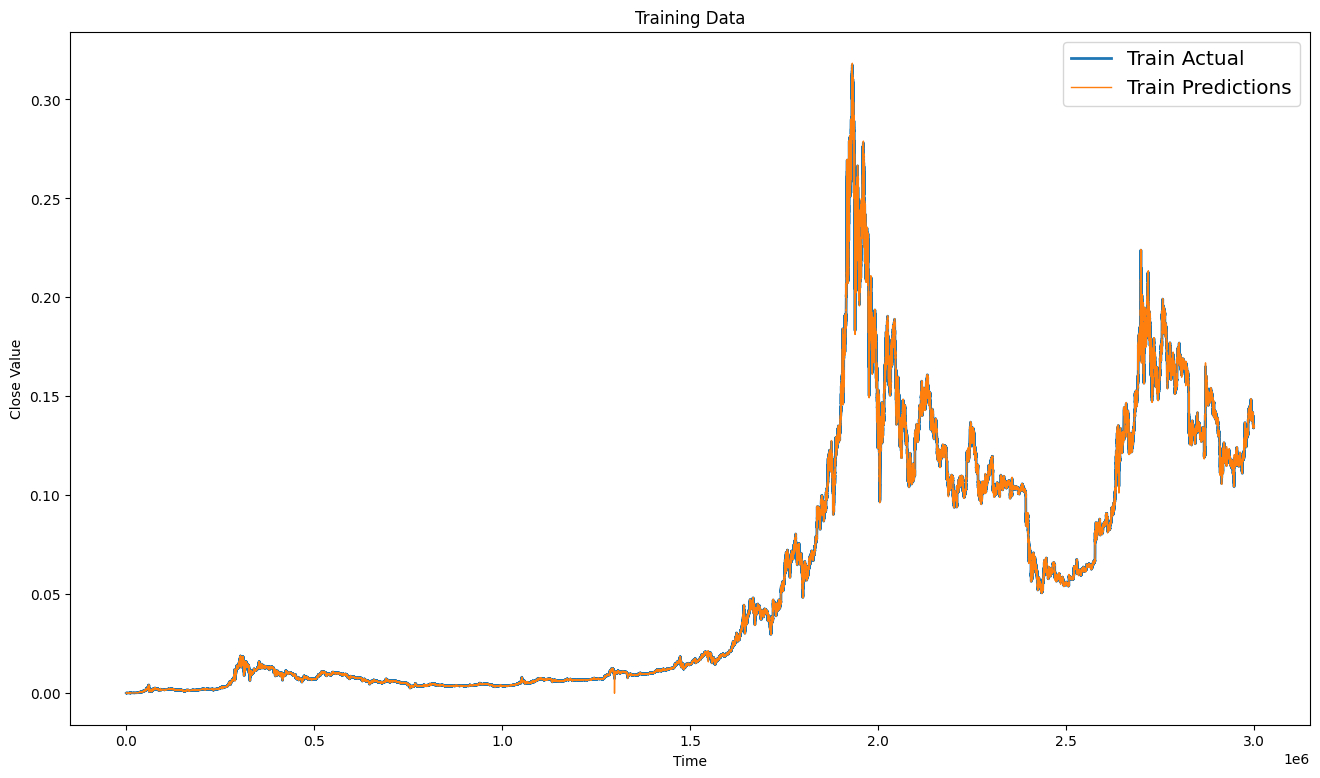

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.title("Training Data")
plt.xlabel("Time")
plt.ylabel("Close Value")
plt.plot(train_results['Train Predictions'], label='Train Actual',linewidth='2')
plt.plot(train_results['Actuals'], label='Train Predictions',linewidth='1' )
plt.legend(loc='upper right',fontsize="x-large")

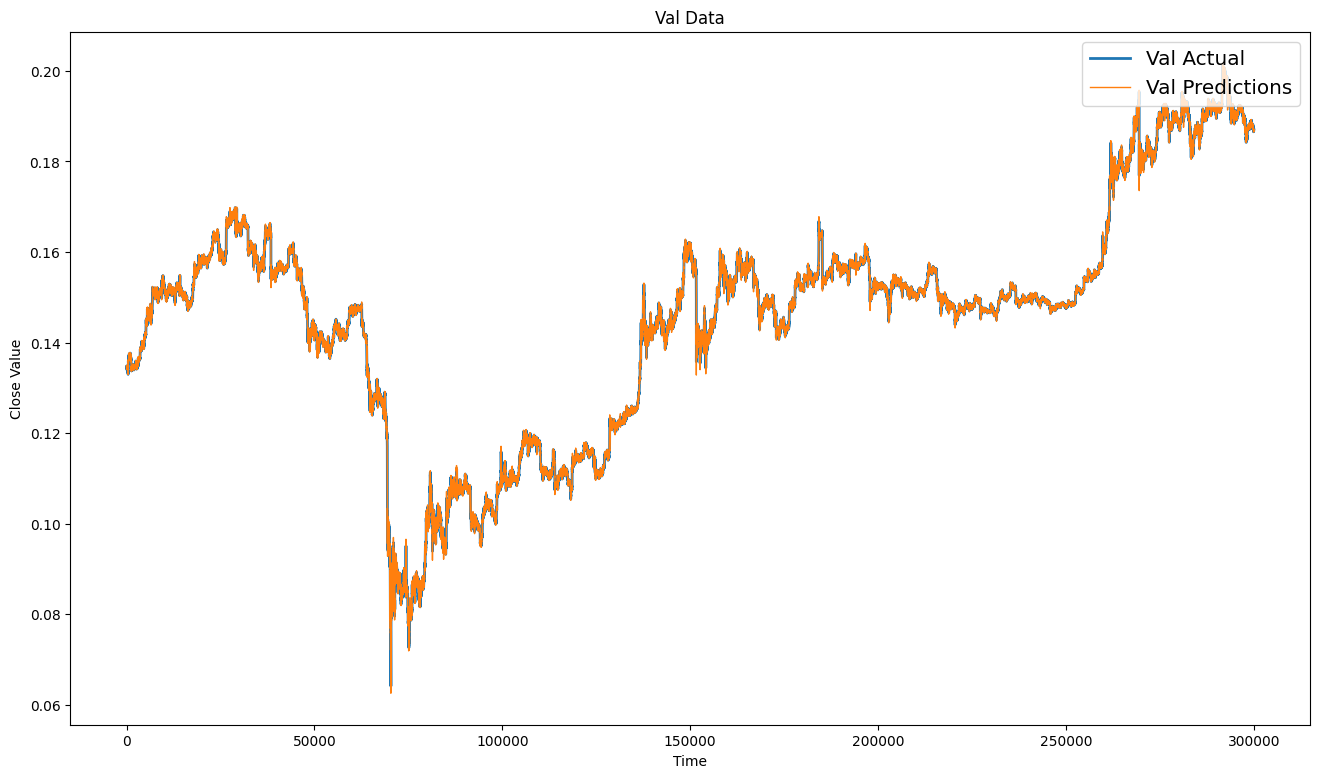

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.title("Val Data")
plt.xlabel("Time")
plt.ylabel("Close Value")

plt.plot(val_results['Train Predictions'], label='Val Actual',linewidth='2')
plt.plot(val_results['Actuals'], label='Val Predictions',linewidth='1' )

plt.legend(loc='upper right',fontsize="x-large")

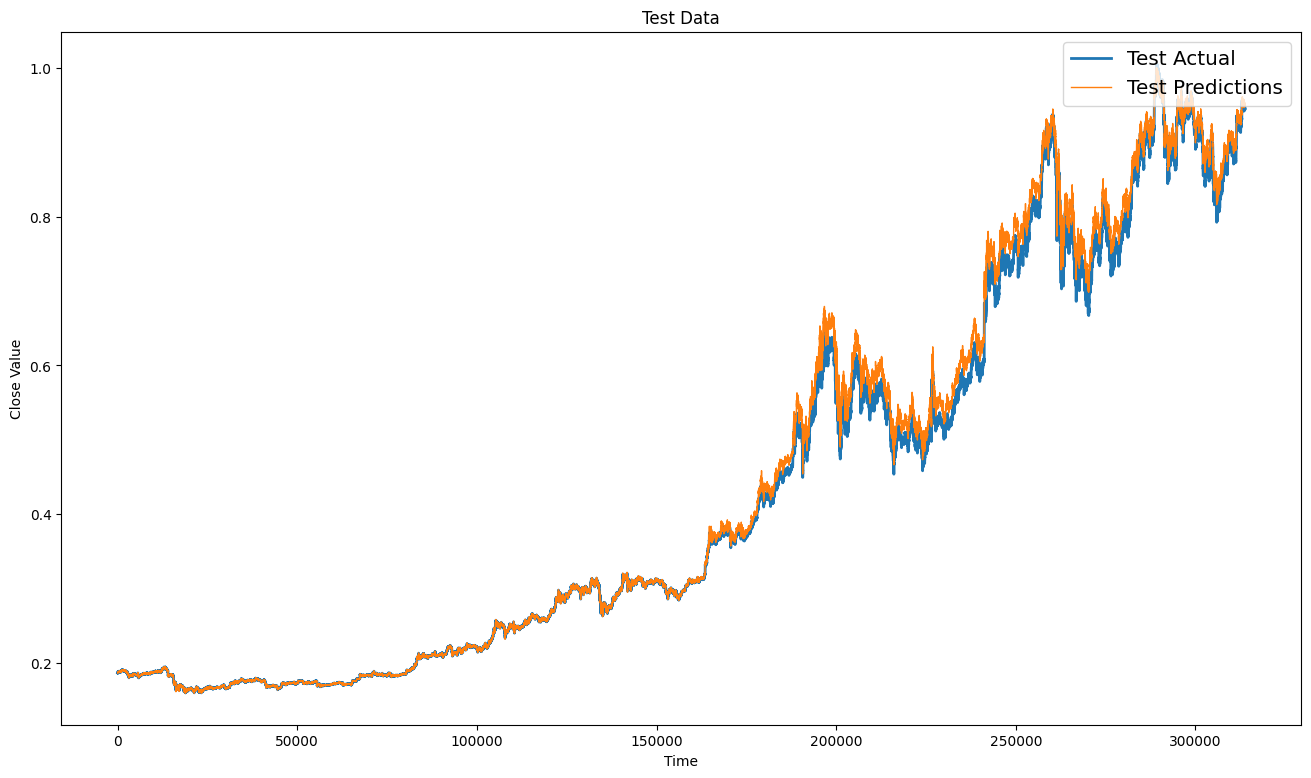

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.title("Test Data")
plt.xlabel("Time")
plt.ylabel("Close Value")
plt.plot(test_results['Test Predictions'], label='Test Actual',linewidth='2')
plt.plot(test_results['Actuals'], label='Test Predictions',linewidth='1' )
plt.legend(loc='upper right',fontsize="x-large")